# Predict Stock Market Based On News Headlines Using NLP And Deep Learn

## 1. Introduction

**Dataset**

there are 2 source of data, 1st data source used for training purposes and 2nd 
source used for inference.
mainly the dataset include information about,
* Date
* Label : value range 0 - 1, 0 if stock decrease or constant, 1 if stock increase
* top1-top25 : news headlines ranging from "Top1" to "Top25".


**Objective**

Objective that i want to achieve from this project is predicting stock movement based on news headlines using NLP and Deep Learning

**Topic Covered**

Deep learn : LSTM & Embedding

## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, LSTM, Embedding, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [4]:
import warnings
warnings.filterwarnings("ignore")

## 3. Data Loading

lets load our 2 data sources which is df is for training purposes while inf for inference later.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Data_headline.csv', encoding='ISO-8859-1')

In [24]:
inf = pd.read_csv('/content/drive/MyDrive/inf_stock.csv')

It seems our data is made of different news headlines related to a company and a label of wether the companies stock price will increase or decrease.(0:decrease, 1: increase)

In [6]:
df.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links


In [116]:
inf.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4101 entries, 0 to 4100
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    4101 non-null   object
 1   Label   4101 non-null   int64 
 2   Top1    4101 non-null   object
 3   Top2    4101 non-null   object
 4   Top3    4101 non-null   object
 5   Top4    4101 non-null   object
 6   Top5    4101 non-null   object
 7   Top6    4101 non-null   object
 8   Top7    4101 non-null   object
 9   Top8    4101 non-null   object
 10  Top9    4101 non-null   object
 11  Top10   4101 non-null   object
 12  Top11   4101 non-null   object
 13  Top12   4101 non-null   object
 14  Top13   4101 non-null   object
 15  Top14   4101 non-null   object
 16  Top15   4101 non-null   object
 17  Top16   4101 non-null   object
 18  Top17   4101 non-null   object
 19  Top18   4101 non-null   object
 20  Top19   4101 non-null   object
 21  Top20   4101 non-null   object
 22  Top21   4101 non-null   

In [115]:
inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1989 non-null   object
 1   Label   1989 non-null   int64 
 2   Top1    1989 non-null   object
 3   Top2    1989 non-null   object
 4   Top3    1989 non-null   object
 5   Top4    1989 non-null   object
 6   Top5    1989 non-null   object
 7   Top6    1989 non-null   object
 8   Top7    1989 non-null   object
 9   Top8    1989 non-null   object
 10  Top9    1989 non-null   object
 11  Top10   1989 non-null   object
 12  Top11   1989 non-null   object
 13  Top12   1989 non-null   object
 14  Top13   1989 non-null   object
 15  Top14   1989 non-null   object
 16  Top15   1989 non-null   object
 17  Top16   1989 non-null   object
 18  Top17   1989 non-null   object
 19  Top18   1989 non-null   object
 20  Top19   1989 non-null   object
 21  Top20   1989 non-null   object
 22  Top21   1989 non-null   

## 4. Data Preprocessing

first thing we going to do in process of clean the text, we will make all the text in lower format.

From inpecting the data, we learned that there are a lot of punctuations which will not contribute to understanding the sentiment in the message. We can use "re.sub(r'[^a-z]+', ' ', headlines[row])" to replace everything apart from a-z with blank space and store in-place in the "data" variable.

stop words removal also applied to remove unecessary word that have unsignificant meaning context

and for grouping together of different forms of the same word also performed lemmatization

after all data clean and neat, we combine all the headlines from top1 to top25 as single text/document

In [33]:
def clean_text(datas, stop_words=True, lemma=True):
    headlines=[]
    lemmatizer = WordNetLemmatizer()
    for row in range(0,len(datas)):
        a = ' '.join([str(i) for i in datas.iloc[row]])
        a = a.lower()
        headlines.append(a)
        headlines[row] = re.sub(r'[^a-z]+', ' ', headlines[row])
        headlines[row] = re.sub(r'\bus\b', 'america', headlines[row])
        if stop_words==True and lemma==False:
            headlines[row] = word_tokenize(headlines[row])
            stop = list(stopwords.words('english'))
            headlines[row] = [i for i in headlines[row] if not (i in stop or len(i)==1)]
            headlines[row] = ' '.join(headlines[row]) 
        elif stop_words==True and lemma==True:
            headlines[row] = word_tokenize(headlines[row])
            stop = list(stopwords.words('english'))
            headlines[row] = [i for i in headlines[row] if not (i in stop or len(i)==1)]
            headlines[row] = [lemmatizer.lemmatize(i, pos='v') for i in headlines[row]]
            headlines[row] = ' '.join(headlines[row]) 
            
    return headlines

In [34]:
df_new = df.copy()
df_new['full_clean'] = clean_text(df.iloc[:,2:], lemma=False)
df_new['lemmatized'] = clean_text(df.iloc[:,2:], lemma=True)

In [35]:
df_new.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,full_clean,lemmatized
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title,hindrance operations extracts leaked reports s...,hindrance operations extract leak report score...
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite,scorecard best lake scene leader german sleaze...,scorecard best lake scene leader german sleaze...
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links,coventry caught counter flo united rivals road...,coventry catch counter flo unite rival road ri...


In time series problems, old data are used to predict later data. Therefore, we set test data to be the latest data.

In [36]:
train = df_new[df_new['Date'] < '20150101']
test = df_new[df_new['Date'] > '20141231']

data_train = train.iloc[:,2:]
data_test = test.iloc[:,2:]

In [37]:
X_train = data_train['lemmatized']
y_train = train['Label']
X_test = data_test['lemmatized']
y_test = test['Label']

tokenizing 3000 first most frequent word and the rest word will be labeled as 'UNK' which have value = 1

In [38]:
tok = Tokenizer(oov_token='UNK', num_words=3000)
tok.fit_on_texts(X_train)

In [39]:
tok.word_index

{'UNK': 1,
 'say': 2,
 'america': 3,
 'new': 4,
 'kill': 5,
 'world': 6,
 'israel': 7,
 'government': 8,
 'police': 9,
 'china': 10,
 'people': 11,
 'war': 12,
 'attack': 13,
 'call': 14,
 'take': 15,
 'make': 16,
 'year': 17,
 'find': 18,
 'one': 19,
 'state': 20,
 'get': 21,
 'russia': 22,
 'report': 23,
 'uk': 24,
 'right': 25,
 'go': 26,
 'years': 27,
 'first': 28,
 'force': 29,
 'time': 30,
 'review': 31,
 'ban': 32,
 'back': 33,
 'plan': 34,
 'use': 35,
 'man': 36,
 'president': 37,
 'face': 38,
 'iran': 39,
 'two': 40,
 'country': 41,
 'israeli': 42,
 'bank': 43,
 'news': 44,
 'protest': 45,
 'may': 46,
 'north': 47,
 'court': 48,
 'minister': 49,
 'russian': 50,
 'leader': 51,
 'korea': 52,
 'unite': 53,
 'warn': 54,
 'give': 55,
 'could': 56,
 'show': 57,
 'death': 58,
 'drug': 59,
 'british': 60,
 'old': 61,
 'military': 62,
 'city': 63,
 'arrest': 64,
 'leave': 65,
 'south': 66,
 'england': 67,
 'un': 68,
 'nuclear': 69,
 'want': 70,
 'fire': 71,
 'london': 72,
 'claim': 73,

converting tokens of text corpus into a sequence of integers.

In [40]:
X_train_seq = tok.texts_to_sequences(X_train)
X_test_seq = tok.texts_to_sequences(X_test)

 to ensure that all sequences in a list have the same length we use padding and fill the rest of length with value = 0

In [41]:
X_train_pad = pad_sequences(X_train_seq, maxlen=150, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=150, padding='post')

In [42]:
X_train_pad[0]

array([   1, 1366,    1,  308,   23,    1, 2491,    1,   87,    1,  988,
       1412,   21,    1, 1236, 1091,    1, 1814,    1,  150,   53,    1,
       1219,    1,    1,    1, 1075,  143, 2972, 1392, 1678,  783,  368,
          1, 2067, 2186,  272, 1181,  356,    1,    1,    1,  618,    1,
         83,  578,   78, 1434,    1,  304, 2922,    1, 2452, 1679,  143,
        141,  849, 1796,  132,    1,    1, 1848,  502,    1,    1,    1,
          1,  711,   87, 2757, 1301, 2758,    1,   67,    1,  173,    1,
          4,  348,    1,    1,    1,  636,  507,    1,  199,   75,    1,
          1, 1867,  132,    1,    1,    1,    1,  163, 1246, 2238,    1,
       2329,  502,  488, 2563, 1479,   50,    1,  261, 2395, 1351,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [43]:
x_train = X_train_pad.reshape(X_train_pad.shape[0], 1, X_train_pad.shape[1])
x_test = X_test_pad.reshape(X_test_pad.shape[0], 1, X_test_pad.shape[1])

In [44]:
print(x_train.shape)
print(x_test.shape)

(3975, 1, 150)
(378, 1, 150)


## 5. Exploratory Data Analysis (EDA)

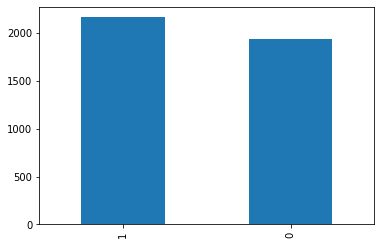

In [ ]:
df['Label'].value_counts().plot.bar()

as we can se in bar plot above, our target or label is pretty balanced

In [ ]:
up = df_new[df_new['Label']==1]
down = df_new[df_new['Label']==0]

In [ ]:
def word_cloud(df):
  full = ' '.join(df)
  cloud = WordCloud()
  clouds = cloud.generate(full)
  plt.figure(figsize=(14,14))
  plt.axis('off');
  return plt.imshow(clouds)

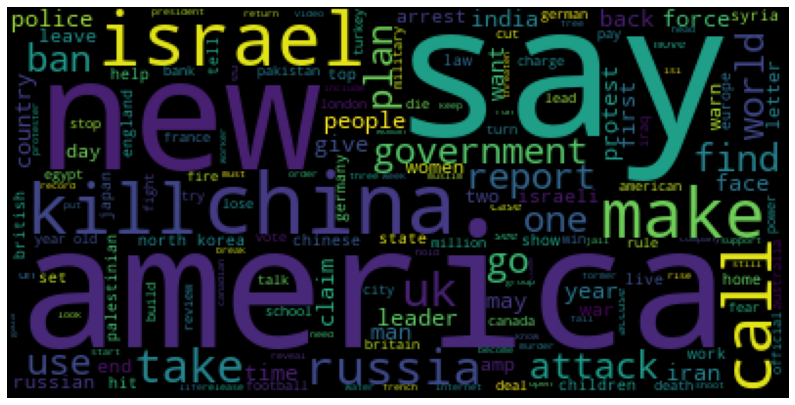

In [ ]:
word_cloud(up['lemmatized'])

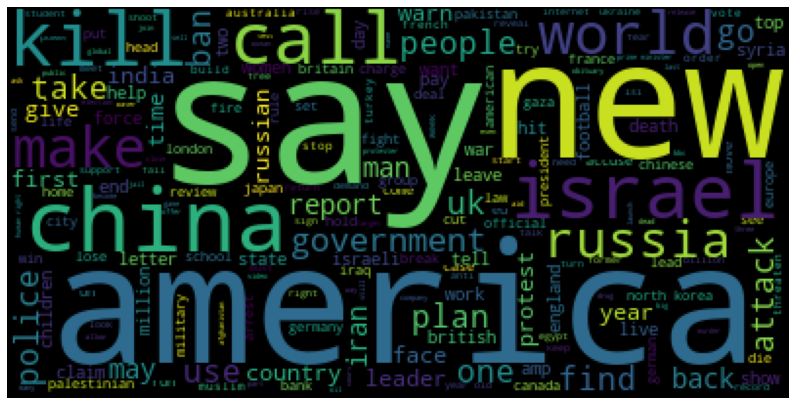

In [ ]:
word_cloud(down['lemmatized'])

In [ ]:
def bar_plots(df):
  full = ' '.join(df)
  tokens = word_tokenize(full)
  frequency = nltk.FreqDist(tokens)
  word = [frequency.most_common(20)[i][0] for i in range(20)]
  freq = [frequency.most_common(20)[i][1] for i in range(20)]
  plt.figure(figsize=(10, 5))
  plt.bar(word, freq)
  plt.xticks(rotation=90)

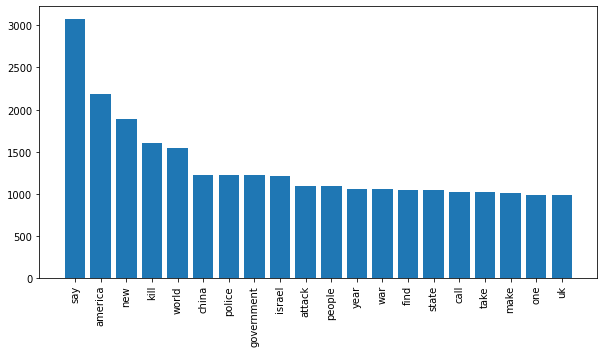

In [ ]:
bar_plots(up['lemmatized'])

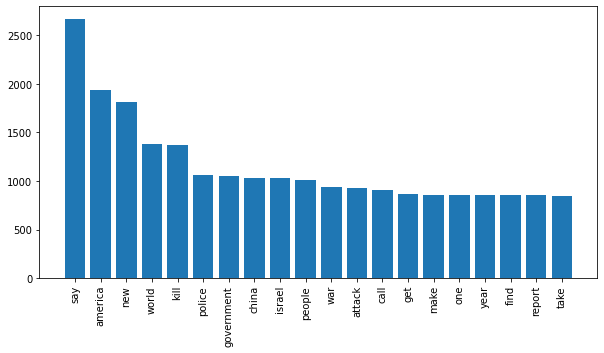

In [ ]:
bar_plots(down['lemmatized'])

## 6. Model Definition, Training, & Evaluation

In [57]:
def evaluation(x):
  metrics = pd.DataFrame(x.history)
  fig, axes = plt.subplots(1,2, figsize=(15,5))
  metrics[['loss', 'val_loss']].plot(ax=axes[0])
  metrics[['accuracy', 'val_accuracy']].plot(ax=axes[1])

In [58]:
def report(feature, og, th, model):
  y_pred = eval(model).predict(feature)
  y_pred = np.where(y_pred > th, 1, 0)
  print(classification_report(og, y_pred))

In [59]:
def conf_matrix(feature, og, th, model):
  y_pred = eval(model).predict(feature)
  y_pred = np.where(y_pred > th, 1, 0)
  print(confusion_matrix(og, y_pred))

### 1st Attempt

as the first try, lets define our model with 2 LSTM layer.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=64).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(buffer_size=64).batch(32)

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5), 
    ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True)
    ]

In [ ]:
model = Sequential()

model.add(LSTM(128, input_shape=(1, 150), return_sequences=True))

model.add(LSTM(64, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))

opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - 4s 13ms/step - loss: 0.6926 - accuracy: 0.5203 - val_loss: 0.6939 - val_accuracy: 0.5185
Epoch 2/50
125/125 [==============================] - 1s 9ms/step - loss: 0.6924 - accuracy: 0.5233 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 3/50
125/125 [==============================] - 1s 10ms/step - loss: 0.6902 - accuracy: 0.5321 - val_loss: 0.6886 - val_accuracy: 0.5317
Epoch 4/50
125/125 [==============================] - 2s 15ms/step - loss: 0.6901 - accuracy: 0.5281 - val_loss: 0.6919 - val_accuracy: 0.5238
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.6901 - accuracy: 0.5379 - val_loss: 0.6921 - val_accuracy: 0.5106
Epoch 6/50
125/125 [==============================] - 1s 12ms/step - loss: 0.6898 - accuracy: 0.5366 - val_loss: 0.6928 - val_accuracy: 0.5159
Epoch 7/50
125/125 [==============================] - 2s 15ms/step - loss: 0.6897 - accuracy: 0.5391 - val_loss: 0.6952 - val_accuracy: 0.4974


it looks like our model is underfit. our model can't learn the dataset using this kind of architecture

### 2nd Attempt

the second attempt, lets apply embedding layer to compress the input feature space into a smaller one.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train)).shuffle(buffer_size=64).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test_pad, y_test)).shuffle(buffer_size=64).batch(32)

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model2.hdf5', monitor='val_loss', save_best_only=True)
    ]

In [ ]:
model2 = Sequential()

model2.add(Embedding(3000, 50, input_length=150))

model2.add(Flatten())

model2.add(Dense(1, activation='sigmoid'))

opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history2 = model2.fit(train_dataset, epochs=100, validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5167 - val_loss: 0.6732 - val_accuracy: 0.5661
Epoch 2/100
125/125 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.8367 - val_loss: 0.5765 - val_accuracy: 0.8571
Epoch 3/100
125/125 [==============================] - 0s 4ms/step - loss: 0.4491 - accuracy: 0.9811 - val_loss: 0.4250 - val_accuracy: 0.8519
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9990 - val_loss: 0.3241 - val_accuracy: 0.8386
Epoch 5/100
125/125 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 1.0000 - val_loss: 0.2873 - val_accuracy: 0.8386
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 0.2772 - val_accuracy: 0.8360
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.2754 - val_accuracy: 0.8333

now there are some progress in our train process. our model seems able to learn the data but unfortunately from the result it look like the model is overfit.

### 3rd Attempt

lets combine now, lets add embedding layer combine with LSTM layer.

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 6), 
    ModelCheckpoint('model3.hdf5', monitor='val_loss', save_best_only=True)
    ]

In [ ]:
model3 = Sequential()

model3.add(Embedding(3000, 50, input_length=150))

model3.add(LSTM(8, activation='sigmoid'))

model3.add(Dense(1, activation='sigmoid'))

opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
model3.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history3 = model3.fit(train_dataset, epochs=100, validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 33s 252ms/step - loss: 0.7074 - accuracy: 0.5273 - val_loss: 0.6981 - val_accuracy: 0.5079
Epoch 2/100
125/125 [==============================] - 32s 256ms/step - loss: 0.6871 - accuracy: 0.5250 - val_loss: 0.6867 - val_accuracy: 0.5079
Epoch 3/100
125/125 [==============================] - 32s 254ms/step - loss: 0.6771 - accuracy: 0.5286 - val_loss: 0.6692 - val_accuracy: 0.5794
Epoch 4/100
125/125 [==============================] - 32s 257ms/step - loss: 0.6559 - accuracy: 0.6023 - val_loss: 0.6411 - val_accuracy: 0.6693
Epoch 5/100
125/125 [==============================] - 31s 246ms/step - loss: 0.6253 - accuracy: 0.6302 - val_loss: 0.6108 - val_accuracy: 0.6799
Epoch 6/100
125/125 [==============================] - 33s 262ms/step - loss: 0.5951 - accuracy: 0.6453 - val_loss: 0.5890 - val_accuracy: 0.7011
Epoch 7/100
125/125 [==============================] - 31s 246ms/step - loss: 0.5706 - accuracy: 0.6589 - val_loss: 0.5690 -

its better now. our model is in good fit with validation accuracy 0.82. so now lets evaluate our model more detail.

In [ ]:
model3.evaluate(train_dataset)

125/125 [==============================] - 8s 66ms/step - loss: 0.3226 - accuracy: 0.8380


[0.3225625455379486, 0.8379874229431152]

In [ ]:
model3.evaluate(valid_dataset)

12/12 [==============================] - 1s 91ms/step - loss: 0.5402 - accuracy: 0.8228


[0.540166437625885, 0.8227513432502747]

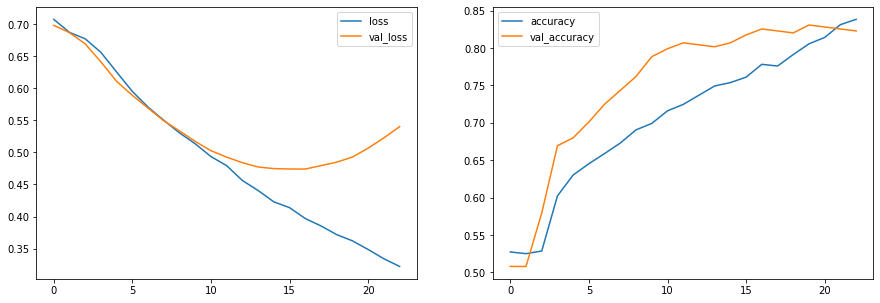

In [ ]:
evaluation(history3)

In [ ]:
report(X_train_pad, y_train, th=0.4, model='model3')

              precision    recall  f1-score   support

           0       0.76      0.98      0.85      1879
           1       0.97      0.72      0.83      2096

    accuracy                           0.84      3975
   macro avg       0.87      0.85      0.84      3975
weighted avg       0.87      0.84      0.84      3975



In [ ]:
report(X_test_pad, y_test, th=0.4, model='model3')

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       186
           1       0.81      0.86      0.84       192

    accuracy                           0.83       378
   macro avg       0.83      0.83      0.83       378
weighted avg       0.83      0.83      0.83       378



from the clasification report above we can conclude that the result is quite good. apart from the accuracy, the f1 score is showing the good result as well, so thats why this model is quite good to predict class 0 and 1.

In [ ]:
conf_matrix(X_test_pad, y_test, th=0.4, model='model3')

[[148  38]
 [ 26 166]]


### 4th Attempt

from the last attempt we got a good model which can predict both class pretty well. so lets do another experiment and make the model more complex by adding more layer.

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5), 
    ModelCheckpoint('model4.hdf5', monitor='val_loss', save_best_only=True)
    ]

In [ ]:
model4 = Sequential()

model4.add(Embedding(3000, 50, input_length=150))

model4.add(LSTM(512, return_sequences=True))

model4.add(LSTM(256, activation='sigmoid', return_sequences=True))

model4.add(LSTM(128, activation='sigmoid'))

model4.add(Dense(1, activation='sigmoid'))

opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
model4.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history4 = model4.fit(train_dataset, epochs=100, validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 72s 550ms/step - loss: 0.7012 - accuracy: 0.5130 - val_loss: 0.6942 - val_accuracy: 0.4921
Epoch 2/100
125/125 [==============================] - 69s 549ms/step - loss: 0.6942 - accuracy: 0.5127 - val_loss: 0.6937 - val_accuracy: 0.5079
Epoch 3/100
125/125 [==============================] - 68s 542ms/step - loss: 0.6953 - accuracy: 0.5107 - val_loss: 0.6947 - val_accuracy: 0.5079
Epoch 4/100
125/125 [==============================] - 67s 537ms/step - loss: 0.6945 - accuracy: 0.5152 - val_loss: 0.6930 - val_accuracy: 0.5079
Epoch 5/100
125/125 [==============================] - 67s 533ms/step - loss: 0.6934 - accuracy: 0.5137 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 6/100
125/125 [==============================] - 66s 527ms/step - loss: 0.6641 - accuracy: 0.5683 - val_loss: 0.6187 - val_accuracy: 0.6746
Epoch 7/100
125/125 [==============================] - 68s 544ms/step - loss: 0.6080 - accuracy: 0.6299 - val_loss: 0.6099 -

In [ ]:
model4.evaluate(train_dataset)

125/125 [==============================] - 5s 43ms/step - loss: 0.3391 - accuracy: 0.8161


[0.3390931189060211, 0.8161006569862366]

In [ ]:
model4.evaluate(valid_dataset)

12/12 [==============================] - 1s 43ms/step - loss: 0.6815 - accuracy: 0.8228


[0.6815199255943298, 0.8227513432502747]

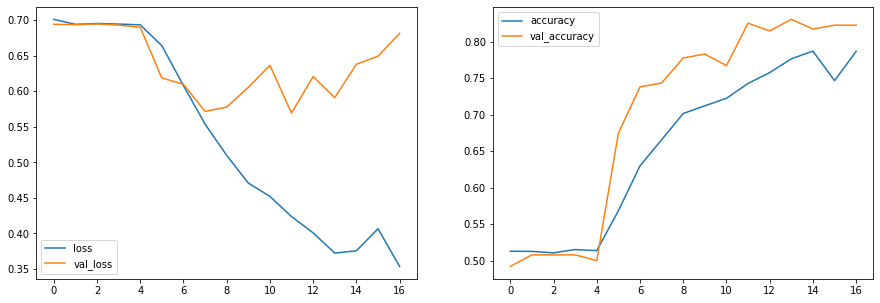

In [ ]:
evaluation(history4)

its look like i cant tell any difference between model4 and model3, or we can simply say that the result is quite identical. so since this model is way more complex that model3, then i decide to use model3 instead.

In [ ]:
report(X_train_pad, y_train, th=0.5, model='model4')

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1879
           1       0.90      0.73      0.81      2096

    accuracy                           0.82      3975
   macro avg       0.83      0.82      0.82      3975
weighted avg       0.83      0.82      0.82      3975



In [ ]:
report(X_test_pad, y_test, th=0.5, model='model4')

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       186
           1       0.83      0.82      0.82       192

    accuracy                           0.82       378
   macro avg       0.82      0.82      0.82       378
weighted avg       0.82      0.82      0.82       378



In [ ]:
conf_matrix(X_test_pad, y_test, th=0.5, model='model4')

[[154  32]
 [ 35 157]]


## 7. Model Saving

In [ ]:
save_model(model3, 'model_stock_best.hdf5')

## 8. Model Inference

lets predict our inference data using model3

In [156]:
inference = inf.tail(500)

In [151]:
inf_y = inference['Label']

In [153]:
inf_clean = clean_text(inference.iloc[:,2:], lemma=True)
inf_seq = tok.texts_to_sequences(inf_clean)
inf_pad = pad_sequences(inf_seq, maxlen=150, padding='post')

In [147]:
model_best = load_model('model3.hdf5')

In [148]:
report(inf_pad, inf_y, th=0.5, model='model_best)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       241
           1       0.86      0.88      0.87       259

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



In [149]:
conf_matrix(inf_pad, inf_y, th=0.5, model='model_best')

[[205  36]
 [ 30 229]]


## 9. Results

some conclusion that you may find usefull about this work.

* best DL model to generalize this dataset is using DL with embedding layer and LSTM layer with 8 units involved.
* best model for this project is model3 which is resulting accuarcy 0.83 and average f1 score for both clasess is 0.83.